In [44]:
from __future__ import unicode_literals,print_function,division
from io import open
import unicodedata
import string
import re
import random
import os
import librosa
import pickle
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import math
import librosa.display

print(torch.__version__)
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

1.5.0
cuda:0


In [59]:
def getData():
    path='wavDatasets//'
    listdir=os.listdir(path)
    data={}
    for x in listdir:
        if 'wav' in x:
            y,rate=librosa.load('wavDatasets//'+x)
            #print(y)
            data[x[0:-4]]=y
    return data

def getLabel():
    df=open('wavDatasets//music_dic.pkl','rb')#注意此处是rb
    #此处使用的是load(目标文件)
    music_dic=pickle.load(df)
    df.close()
    label={}
    for x in music_dic.keys():
        y=music_dic[x]
        label[x]=one_hot(y)
    return label

#得到note和num字典
def getDict():
    note_dic = {}
    note = ['<S>','<E>','C4', 'C4#', 'D4', 'D4#', 'E4', 'F4', 'F4#', 'G4',
            'G4#', 'A4', 'A4#', 'B4', 'C5', 'C5#', 'D5', 'D5#',
            'E5', 'F5', 'F5#', 'G5', 'G5#', 'A5', 'A5#', 'B5',
            'C6', 'C6#', 'D6', 'D6#', 'E6', 'F6', 'F6#', 'G6',
            'G6#', 'A6', 'A6#', 'B6', 'C7', 'C7#']

    for x in range(len(note)):
        if note[x] not in note_dic.keys():
            # onehot = np.zeros(len(note))
            # onehot[x] = 1
            note_dic[note[x]] = x
    num_dic=dict(zip(note_dic.values(),note_dic.keys()))

    return note_dic,num_dic

def one_hot(y):
    note_dic = getDict()[0]
    note=[]
    note.append(note_dic['<S>'])
    for x in y:
        note.append(note_dic[x])
    note.append(note_dic['<E>'])
    return note

#会调用前面的函数，最后返回训练集的数据
#形状为（x_train,y_train)，x_train是训练集音频数据，y_train是训练集数据标签
#数据类型均为torch.longtensor
def getPair():
    x=getData()
    #print(x)
    y=getLabel()
    data=[]
    label=[]
    for key in x.keys():
        a=x[key]
        a=list(a)#[random.randint(100,120):random.randint(120,140)]
        a=torch.Tensor(a).view(len(a),1).half()
        b=torch.Tensor(y[key]).view(len(y[key]),1).half()
        a = a.to(device)
        #print(a)
        b = b.to(device)
        data.append(a)
        label.append(b)
    return data,label



#获取数据和字典
x_train, y_train = getPair()
MAX_LENGTH = max([i.shape[0] for i in x_train])
note_dic,num_dic=getDict()#得到字典
S_token=0#代表句子的开始
E_token=1#代表句子的结束

#不要动它
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [60]:
x_train[0]

tensor([[-9.4757e-03],
        [ 9.8633e-02],
        [-7.0862e-02],
        [ 5.2216e-02],
        [-9.7427e-03],
        [-4.3518e-02],
        [ 6.4392e-02],
        [-6.5247e-02],
        [ 5.6946e-02],
        [-4.8370e-02],
        [ 3.5004e-02],
        [-2.0294e-02],
        [ 6.9666e-04],
        [ 1.8311e-02],
        [-5.5054e-02],
        [ 6.0005e-03],
        [-1.1536e-02],
        [ 7.0877e-03],
        [-5.9242e-03],
        [ 6.6032e-03],
        [-2.0370e-03],
        [ 1.0099e-03],
        [ 2.9349e-04],
        [-2.4052e-03],
        [ 6.1264e-03],
        [-1.8219e-02],
        [-1.4992e-02],
        [ 6.4583e-03],
        [-6.4163e-03],
        [ 3.5725e-03],
        [ 2.8181e-04],
        [ 1.4534e-03],
        [-4.7922e-04],
        [ 9.6917e-05],
        [ 8.6975e-04],
        [-6.2847e-04],
        [ 2.2590e-04],
        [-1.5440e-03],
        [ 1.0347e-03],
        [-1.1702e-03],
        [ 9.4509e-04],
        [-9.5558e-04],
        [ 8.1444e-04],
        [-6

In [61]:
#不要动它
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length=max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat([embedded[0], hidden[0]], 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat([embedded[0], attn_applied[0]], 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#不要动它
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,maxlen=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(maxlen, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[S_token]], device=device)

    decoder_hidden = encoder_hidden
    teacher_forcing_ratio=0.5
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the targer as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing


    else:
        # Without teaching forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == E_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#不要动它
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#不要动它
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [62]:
#epochs是训练迭代次数
def trainIters(encoder, decoder, n_iters, print_every=1, plot_every=1, learning_rate=0.01,epochs=10):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()
    for epoch in range(epochs):
        print('epoch:',epoch)
        for iter in range(1, n_iters + 1):
            print('iter:',iter)
            input_tensor = x_train[iter-1]
            target_tensor = y_train[iter-1]
            print('input_tensor:',input_tensor.size())
            print('target_tensor:',target_tensor.size())

            loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

            print_loss_total += loss
            plot_loss_total += loss
            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
    showPlot(plot_losses)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#不要动它
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

#不要动它
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = sentence
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[S_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            # print(topi.item())
            if topi.item() == E_token:
                # print('<E>')
                decoded_words.append('<E>')
                break
            else:
                # print(di,num_dic[topi.item()])
                decoded_words.append(num_dic[topi.item()])


            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#x_test是测试音频数据
#y_test是测试数据标签
#n是测试数据的数量
def evaluateRandomly(encoder, decoder, x_test,y_test=None,n=1):
    for i in range(n):
        print('>', x_test[i].size())
        print('=', y_test[i].size())
        output_words, attentions = evaluate(encoder, decoder, x_test[i])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        return output_words

In [63]:
hidden_size = 256
#20是可调参数
encoder1 = EncoderRNN(20, hidden_size).to(device)
#38不可调，千万不要动。
attn_decoder1 = AttnDecoderRNN(hidden_size, 38, dropout_p=0.1).to(device)
#20是训练集数据的个数，可以小于，但不能大于
#epochs是可调参数，代表训练次数

In [65]:
encoder1

EncoderRNN(
  (embedding): Embedding(20, 256)
  (gru): GRU(256, 256)
)

In [66]:
attn_decoder1

AttnDecoderRNN(
  (embedding): Embedding(38, 256)
  (attn): Linear(in_features=512, out_features=552, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=38, bias=True)
)

In [64]:

trainIters(encoder1, attn_decoder1, 20,epochs=10)

torch.save(encoder1,'ecnoder1.pkl')
torch.save(attn_decoder1,'attn_decoder1.pkl')
#x_train和y_train是测试数据。
#n代表测试多少个测试数据
x_train = torch.tensor(x_train,device=device)
y_train = torch.tensor(y_train,device=device)
#y_train.to(device)
res=evaluateRandomly(encoder1, attn_decoder1,x_train,y_train,n=1)

epoch: 0
iter: 1
input_tensor: torch.Size([508, 1])
target_tensor: torch.Size([22, 1])


RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.cuda.HalfTensor instead (while checking arguments for embedding)

In [31]:
x_train = torch.tensor(x_train)

ValueError: only one element tensors can be converted to Python scalars

In [34]:
len(x_train)

1000

Text(0.5, 1.0, 'Monophonic')

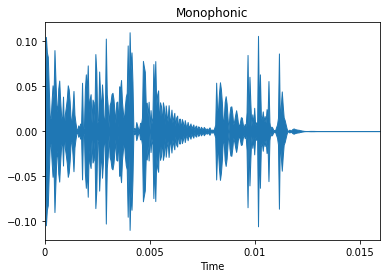

In [45]:
y, sr = librosa.load('wavDatasets/2020-05-26_17_15_16_0.wav')
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

In [52]:

import wave
f = wave.open("wavDatasets/2020-05-26_17_15_16_0.wav", "rb")
# 读取格式信息
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
# 读取波形数据
str_data = f.readframes(nframes)
f.close()
#将波形数据转换为数组
wave_data = np.fromstring(str_data, dtype=np.short)
wave_data.shape = -1, 2
wave_data = wave_data.T
time = np.arange(0, nframes) * (1.0 / framerate)
# 绘制波形

plt.plot(time, wave_data[0])

plt.plot(time, wave_data[1], c="g")

Error: unknown format: 3